# Preprocessing

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import datetime as dt
import math

from sklearn.preprocessing import MinMaxScaler

# Visualization 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, dash_table
from dash.dependencies import Input, Output, State
import ipywidgets as widgets
from IPython.display import clear_output


In [2]:
# Import raw data
rawdf = pd.read_csv('APAC Data Analytics Case Study.csv')
rawdf.head()

,Unnamed: 0,pspreference,currencycode,issuercountrycode,bin,creationdate,genericresponse,amount,scheme,merchant,company,acquireraccount,acquirer,journaltype,paymentmethod,approved,refused,received,threedattempt
0,1,psp:89068059460259968,IDR,ID,552695,2017-10-01 18:58:11,APPROVED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Cancelled,commercialcredit,1,0,1,Yes
1,2,psp:67025064257904888,IDR,ID,547582,2017-10-01 12:47:47,APPROVED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Cancelled,commercialcredit,1,0,1,Yes
2,3,psp:61362098320387304,IDR,ID,547582,2017-10-01 22:44:06,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes
3,4,psp:78486269968561824,IDR,ID,547582,2017-10-01 22:41:30,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes
4,5,psp:6116164638660848,IDR,KR,558420,2017-10-01 21:56:04,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes


In [3]:
for col in rawdf:
    print(col)
    print(rawdf[col].unique())
    print(len(rawdf[col].unique()))
    print('----------------------------------------')
    
# assume all merchants have no relation to each other, therefore cant cross compare across merchants in the market / conduct market analysis 

Unnamed: 0
[     1      2      3 ... 226866 226867 226868]
226868
----------------------------------------
pspreference
['psp:89068059460259968' 'psp:67025064257904888' 'psp:61362098320387304'
 ... 'psp:20574157754890620' 'psp:73109800834208720'
 'psp:1238853996619582']
226868
----------------------------------------
currencycode
['IDR' 'MYR' 'SGD' 'THB']
4
----------------------------------------
issuercountrycode
['ID' 'KR' 'IN' 'US' nan 'NL' 'GB' 'MY' 'DE' 'HK' 'SG' 'FR' 'VN' 'TW' 'CN'
 'HU' 'CA' 'CL' 'BR' 'AU' 'CZ' 'PH' 'MX' 'RU' 'ES' 'LB' 'AR' 'SA' 'SI'
 'ZA' 'JP' 'TR' 'EG' 'TH' 'AE' 'LK' 'NO' 'CO' 'PK' 'BN' 'KE' 'SE' 'QA'
 'KW' 'NZ' 'AT' 'SR' 'IT' 'CH' 'KH' 'MO' 'BE' 'PL' 'DK' 'IE' 'BY' 'CR'
 'NG' 'EE' 'FI' 'PE' 'IL' 'LV' 'UA' 'BG' 'EC' 'KZ' 'PR' 'SO' 'BZ' 'TC'
 'PA' 'LT' 'OM' 'PT' 'JO' 'MM' 'BD' 'DO' 'RS' 'RO' 'HR' 'AM' 'LU' 'UY'
 'FJ' 'SK' 'MT' 'BB' 'HN' 'GI' 'PY' 'JM' 'SV' 'ZM' 'MU' 'BM' 'AF' 'MV'
 'TJ' 'IS' 'SM' 'MN' 'LA' 'AD' 'TT' 'VE' 'BH' 'GT' 'KG' 'GR' 'UZ' 'AG'
 'TZ' 'BA

## Data Cleaning

In [120]:
df = rawdf.copy() 
df = df.drop(['Unnamed: 0', 'received'], axis=1)

df['issuercountrycode'] = np.where(df['issuercountrycode'].isna(), 'unspecified', df['issuercountrycode'])

## Feature Engineering

In [121]:
# Rename boolean field outputs
df['is_approved'] = np.where(df['approved'] ==1, 'Approved', 'Rejected') # 1= approved, 0 = refused
df['threedattempt'] = np.where(df['threedattempt'] == 'Yes', 'Secure', 'Not_Secure') #1= Ready to support native 3D Secure 2 authentication

# Identify FRAUD transactions
df['is_fraud'] = np.where(df['genericresponse'] == 'FRAUD', 'Fraud', 'Not_Fraud')

# Time & Day
df['date_time'] = pd.to_datetime(df['creationdate'])
df['date'] = df['date_time'].dt.date
df['day'] = df['date_time'].dt.day_name()
df['weektype'] = np.where(df['day'].isin(['Saturday', 'Sunday']), 'weekend', 'weekday')

df['hour'] = df['date_time'].dt.hour
df['timeofday'] = np.where(df['hour'].isin(np.arange(6, 12)), 'day', 
                          np.where(df['hour'].isin(np.arange(12, 18)), 'afternoon', 
                          np.where(df['hour'].isin(np.arange(18, 24)), 'night', 
                          np.where(df['hour'].isin(np.arange(0, 6)), 'latenight', 
                          'unspecified'))))

# Transaction type: shopper type
df['domestic_shopper'] = np.where(df['currencycode'].str[:2] == df['issuercountrycode'], 1, 0)

In [122]:
# Payment method by card type
normal = ['credit', 'debit', 'standardcredit', 'standarddebit']
premium = ['premiumcredit', 'premiumdebit', 'superpremiumcredit', 'superpremiumdebit']
commercial = ['commercialcredit', 'commercialdebit', 'commercialpremiumcredit', 'commercialpremiumdebit', 'commercialsuperpremiumcredit']
corporate = ['corporatecredit', 'corporatedebit', 'fleetcredit', 'purchasingcredit', 'proprietary']

df['cardtype'] = np.where(df['paymentmethod'].isin(normal), 'normal', 
                          np.where(df['paymentmethod'].isin(premium), 'premium', 
                          np.where(df['paymentmethod'].isin(commercial), 'commercial', 
                          np.where(df['paymentmethod'].isin(corporate), 'corporate', 
                          'unspecified'))))

# Payment method by payment card
df['debit_credit'] = np.where(df['paymentmethod'].str.contains('credit'), 'credit', 
                          np.where(df['paymentmethod'].str.contains('debit'), 'debit',
                          'proprietary'))

In [123]:
# Categorize journal type
captured =['Authorised', 'SettledExternally', 'Settled', 'SentForSettle', 'SettledBulk']
tryagain =['Cancelled', 'Expired', 'CaptureFailed']
refunds =['RefundedExternally', 'Refunded', 'RefundFailed', 'SentForRefund']
refused =['Refused', 'Error'] # there are no refused journal type under genericersponse == Approved

df['journalcat'] = np.where(df['journaltype'].isin(captured), 'captured', 
                          np.where(df['journaltype'].isin(tryagain), 'tryagain', 
                          np.where(df['journaltype'].isin(refunds), 'refunds', 
                          np.where(df['journaltype'].isin(refused), 'refused', 
                          'unspecified'))))

Index(['IDR', 'MYR', 'SGD', 'THB'], dtype='object')


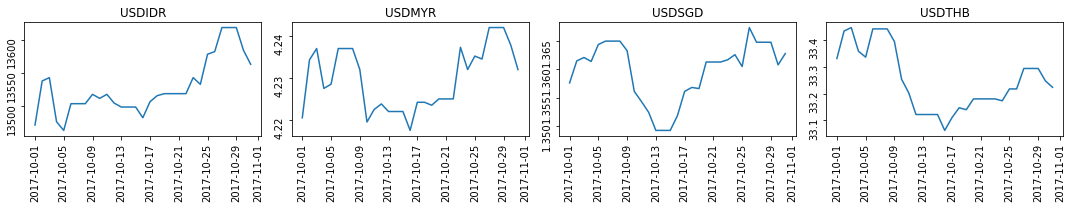

In [124]:
# Convert all amount to USD for standardization 

# Import fx rate data
fxdf = pd.read_csv('currency.csv')
fxdf['date'] = pd.to_datetime(fxdf['date'])

currencies = fxdf.columns[1:]
print(currencies)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
ind = 0
while ind < 4:
    axs[ind].plot(np.array(fxdf['date']) , np.array(fxdf[currencies[ind]]), label = currencies[ind])
    axs[ind].title.set_text('USD' +currencies[ind])
    axs[ind].tick_params(labelrotation=90)
    ind += 1
    
plt.tight_layout()
plt.show()

In [125]:
# Melt fx data 
fxdf_melt = pd.melt(fxdf, id_vars =['date'], value_vars = fxdf.columns[1:]).dropna()
fxdf_melt['date'] = fxdf_melt['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
fxdf_melt.columns = ['date_str', 'currencycode', 'fx_rate']

# Merge fx data into main df on date and currency
df['date_str'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df2 = pd.merge(df, fxdf_melt, how='left', on=['date_str', 'currencycode'])

# Get amount spent in standardized currency: USD
df2['amount_usd'] = df2['amount'] / df2['fx_rate']

,amount_bin,pspreference
0,micro,64290
1,small,69075
2,average,38947
3,large,54364
4,massive,192


<BarContainer object of 5 artists>

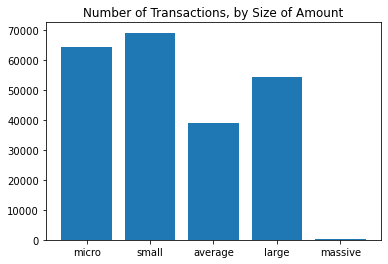

In [126]:
# Bin amount into sizes
df2['amount_bin'] =  pd.cut(df2['amount_usd'] , bins=[0.0, 1.0, 25, 500, 10000, 100000], 
                            labels= ['micro', 'small', 'average', 'large', 'massive']) # Ballparked bins based on 25%, 50% and 75%
t1 = df2.groupby(['amount_bin'])['pspreference'].count().reset_index()
display(t1)
plt.title('Number of Transactions, by Size of Amount')
plt.bar(t1.amount_bin.astype(str), t1.pspreference)

In [127]:
# Drop irrelevant columns
df2 = df2.drop(['amount', 'date_str', 'approved', 'refused', 'fx_rate', 'hour', 'creationdate'], axis =1) # fx rate is for standardization only, assume merchant does not bear any fx loss
df2.sample(5)

,pspreference,currencycode,issuercountrycode,bin,genericresponse,scheme,merchant,company,acquireraccount,acquirer,...,date,day,weektype,timeofday,domestic_shopper,cardtype,debit_credit,journalcat,amount_usd,amount_bin
85937,psp:22702238941565156,SGD,SG,426588,APPROVED,visa,XYZ_SGD,XYZLimited,AdyenVisaSingapore_XYZ_SGD,AdyenVisaSingapore,...,2017-10-12,Thursday,weekday,afternoon,1,premium,credit,captured,3697.131026,large
72749,psp:17226681392639876,IDR,ID,540912,APPROVED,mastercard,ABC_IDR,ABCLimited,AdyenVisaMalaysia_ABC_IDR,AdyenVisaMalaysia,...,2017-10-11,Wednesday,weekday,day,1,premium,credit,captured,0.665779,micro
72919,psp:98333593108691280,IDR,ID,436502,APPROVED,visa,ABC_IDR,ABCLimited,AdyenVisaMalaysia_ABC_IDR,AdyenVisaMalaysia,...,2017-10-11,Wednesday,weekday,day,1,normal,credit,tryagain,0.073975,micro
161812,psp:1285569975152612,MYR,FR,535298,APPROVED,mastercard,ABC_MYR,ABCLimited,AdyenMasterCardMalaysia_ABC_MYR,AdyenMasterCardMalaysia,...,2017-10-23,Monday,weekday,day,0,normal,debit,tryagain,23.599934,small
17375,psp:31128229526802896,IDR,MY,549782,DECLINED,mastercard,DEF_IDR,DEFLimited,AdyenMasterCardEurope_DEF_IDR,AdyenMasterCardEurope,...,2017-10-03,Tuesday,weekday,afternoon,0,normal,debit,refused,0.553792,micro


# EDA

## Descriptive Summary

In [128]:
# Lists
companies = np.unique(df2.company)
dates = np.unique(df2.date)
days = np.unique(df2.day)
cards = np.unique(df2.cardtype)
schemes = np.unique(df2.scheme)
journals = list(np.unique(df2.journalcat)) + ['All']

# List of fields available to filter on
fieldtypes = [elem for elem in df2.columns if elem not in ['pspreference', 'bin', 'company', 'amount_usd', 'date_time', 'date']]
fieldtypes = sorted(fieldtypes)

# Summary statistics
df2.describe()
# df2.loc[:, ~df2.columns.isin(['pspreference', 'creationdate', 'amount'])].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1).style.background_gradient(cmap='coolwarm')

,bin,domestic_shopper,amount_usd
count,226868.000000,226868.000000,226868.000000
mean,491153.083432,0.861408,531.510847
std,50233.273537,0.345521,1292.215587
min,400000.000000,0.000000,0.036716
25%,450824.000000,1.000000,0.665779
50%,498001.000000,1.000000,23.615539
75%,540912.000000,1.000000,444.005929
max,591882.000000,1.000000,73364.177132


<ipython-input-129-36ff1664efd4>:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



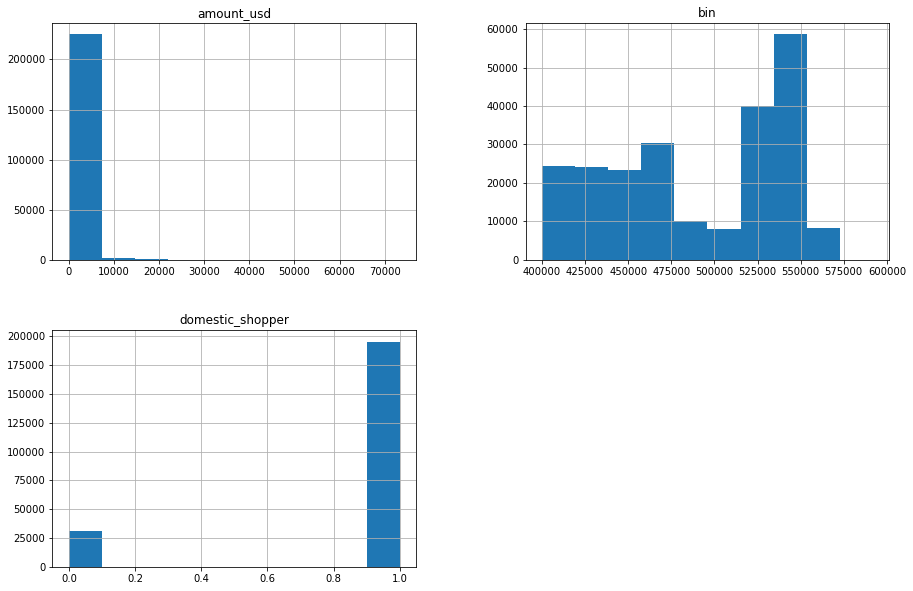

In [129]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df2.hist(ax = ax);

## Transaction flow (sankey)

In [130]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 cat cols -> 6 colors
    colorPalette = ['#4B8BBE','#309871','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
#         
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = [str(i) for i in labelList],
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = go.Figure(data= dict(data=[data], layout=layout))
    return fig


# # Test
# company_dd = 'ABCLimited' 
# field1_dd = 'is_approved'
# field2_dd = 'merchant'
# field3_dd = 'journaltype'

# df_view = df2[df2['company'] == company_dd]
# fig = genSankey(df_view, cat_cols = [field1_dd, field2_dd, field3_dd], 
#             value_cols='amount_usd', title=f'TPV flow of {company_dd}')
# fig.show()

In [138]:
# Plot Sankey

# Initiale df filter
company_dd = 'ABCLimited' 
field1_dd = 'threedattempt'
field2_dd = 'merchant'
field3_dd = 'journaltype'

df_view = df2[df2['company'] == company_dd]

# Widgets
company_dd = widgets.Dropdown(options= companies, value= companies[0], description='Select Company',
                              style= {'description_width': 'initial'})
field1_dd = widgets.Dropdown(options= fieldtypes, value= 'threedattempt', description='Select Field 1',
                              style= {'description_width': 'initial'})
field2_dd = widgets.Dropdown(options= fieldtypes, value= 'merchant', description='Select Field 2',
                              style= {'description_width': 'initial'})
field3_dd = widgets.Dropdown(options= fieldtypes, value= 'journaltype', description='Select Field 3',
                              style= {'description_width': 'initial'})

def callback(__):
    clear_output(wait=True)
    main_box.children = [setup_ui, button_run]
    display(main_box)
    
    # Get Dataframe and plot
    df_view = df2[df2['company'] == company_dd.value]
    txn_flow = genSankey(df_view, cat_cols = [field1_dd.value, field2_dd.value, field3_dd.value], 
                        value_cols='amount_usd', title=f'TPV flow of {company_dd.value}')
    
    return txn_flow.show()

# Show
setup_ui = widgets.VBox([company_dd, field1_dd, field2_dd, field3_dd])
display(setup_ui)

button_run = widgets.Button(description='Run')
main_box = widgets.VBox([button_run])
button_run.on_click(callback)

display(main_box)

## Merchant Performance Overview

In [139]:
def plot_merchant_overview(df, company_dd, field_dd, target_dd):
    df_comp = df[df['company'] == company_dd]
    if target_dd != 'All':
        df_comp = df_comp[df_comp['journalcat'] == target_dd]

    overview_df = df_comp.groupby('date')['amount_usd'].mean().reset_index()
    field_df = df_comp.groupby(field_dd)['amount_usd'].mean().reset_index()

    # Time series
    fig = make_subplots(rows=2, cols=2,specs=[[{}, {'type':'domain'}], [{}, {}]],
                            subplot_titles=['Avg Revenue Across Time',
                                            f'Revenue Distribution by {field_dd}',
                                           'Intraday Revenue', 'Daily Revenue'])

    fig.add_trace(go.Scatter(x=overview_df['date'], y=overview_df['amount_usd']), row=1, col=1)
    fig.add_trace(go.Pie(labels=field_df[field_dd], values=field_df['amount_usd']),row=1, col=2)

    for merc in np.unique(df_comp[field_dd]):
        temp_df = df_comp[df_comp[field_dd] == merc].groupby(['timeofday'])['amount_usd'].mean().reset_index()
        fig.add_trace(go.Bar(x=temp_df['timeofday'],
                             y=temp_df['amount_usd'], 
                             name = str(merc)),
                                row=2, col=1)
        fig.update_xaxes(categoryorder='array', categoryarray= ['day','afternoon','night','latenight'], row=2, col=1)

        temp_df = df_comp[df_comp[field_dd] == merc].groupby(['day'])['amount_usd'].mean().reset_index()
        fig.add_trace(go.Bar(x=temp_df['day'],
                             y=temp_df['amount_usd'], 
                             name = str(merc)),
                            row=2, col=2)
        fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                         , row=2, col=2)


    fig.update_layout(barmode='relative', title_text= f"{company_dd} for {target_dd} Transactions", showlegend=False)
    return fig

## To Test
# company_dd = companies[2]
# field_dd = 'amount_bin' #fieldtypes[-2]
# target_dd = journals[3]
# plot_merchant_overview(df2, company_dd, field_dd, target_dd)

In [140]:
# TODO: Switch between TPV and Volume 

# Initiate filters
company_dd = companies[2]
field_dd = fieldtypes[-2]
target_dd = journals[3]

df_comp = df2[df2['company'] == company_dd]

# Widgets
company_dd = widgets.Dropdown(options= companies, value= companies[0], description='Select Company',
                              style= {'description_width': 'initial'})
field_dd = widgets.Dropdown(options= fieldtypes, value= fieldtypes[3], description='Select Field for Revenue Breakdown',
                              style= {'description_width': 'max-content'},
                           layout= {'width': 'max-content'})
target_dd = widgets.Dropdown(options= journals, value= 'All', description='Select Target Transaction status',
                              style= {'description_width': 'initial'})

def callback(__):
    clear_output(wait=True)
    main_box.children = [setup_ui, button_run]
    display(main_box)
    
    fig = plot_merchant_overview(df2, company_dd.value, field_dd.value, target_dd.value)
    return fig.show()

# Show
setup_ui = widgets.VBox([company_dd, field_dd, target_dd])
display(setup_ui)

button_run = widgets.Button(description='Run')
main_box = widgets.VBox([button_run])
button_run.on_click(callback)

display(main_box)

# Analysis

## Fraud Analysis

In [147]:
company_dd = companies[0]
fraud_df = df2[df2['company'] == company_dd]


fraud_stat= fraud_df.groupby(['is_fraud']).agg({'pspreference':'nunique',
                                   'bin': 'nunique',
                                   'amount_usd': 'mean'}).reset_index()
fraud_stat.columns = ['is_fraud', 'n_txns', 'n_cards', 'amount_usd']
display(fraud_stat)

print(f'{fraud_stat.loc[1,"n_txns"]/(fraud_stat.loc[1,"n_txns"]+fraud_stat.loc[0,"n_txns"]) *100: .2f}% of transaction count is fraud for {company_dd}')
print(f'{fraud_stat.loc[1,"n_cards"]/(fraud_stat.loc[1,"n_cards"]+fraud_stat.loc[0,"n_cards"]) *100: .2f}% of cards are fraud for {company_dd}')

if fraud_stat.loc[1,"amount_usd"] < fraud_stat.loc[0,"amount_usd"]:
    print(f'The average fraud transaction is smaller than non-fraud transaction.')
else:
    print(f'The average fraud transaction is larger than non-fraud transaction.')

,is_fraud,n_txns,n_cards,amount_usd
0,Fraud,10509,925,546.956912
1,Not_Fraud,90143,2436,493.945389


 89.56% of transaction count is fraud for ABCLimited
 72.48% of cards are fraud for ABCLimited
The average fraud transaction is smaller than non-fraud transaction.


In [152]:
# Plot fraud vs non-fraud
def fraud_barchart(fraud_df, company_dd, field_dd):
    temp_df = fraud_df.groupby(['is_fraud', field_dd])['amount_usd'].mean().reset_index()
    fig = make_subplots(rows=1, cols=1, subplot_titles= (''))

    for i in ['Not_Fraud', 'Fraud']:
        temp_df2 = temp_df[temp_df['is_fraud'] == i]
        fig.add_trace(go.Bar(x=temp_df2[field_dd], y=temp_df2['amount_usd'], name = i), row=1, col=1)

    fig.update_layout(barmode='group', title_text=f'{company_dd} Avg amount, by {field_dd}', showlegend=True)
    return fig

# # test
# company_dd = companies[2]
# field_dd = 'amount_bin' #fieldtypes[3]
# fraud_df = df2[df2['company'] == company_dd]
# fraud_barchart(fraud_df, company_dd, field_dd)

In [153]:
# Initiate filters
company_dd = companies[2]
field_dd = 'amount_bin' #fieldtypes[3]

fraud_df = df2[df2['company'] == company_dd]

# Widgets
company_dd = widgets.Dropdown(options= companies, value= companies[0], description='Select Company',
                              style= {'description_width': 'initial'})
field_dd = widgets.Dropdown(options= fieldtypes, value= fieldtypes[3], description='Select Field',
                              style= {'description_width': 'max-content'},
                           layout= {'width': 'max-content'})

def callback(__):
    clear_output(wait=True)
    main_box.children = [setup_ui, button_run]
    display(main_box)
    
    fraud_df = df2[df2['company'] == company_dd.value]
    fig = fraud_barchart(fraud_df, company_dd.value, field_dd.value)
    return fig.show()

# Show
setup_ui = widgets.VBox([company_dd, field_dd])
display(setup_ui)

button_run = widgets.Button(description='Run')
main_box = widgets.VBox([button_run])
button_run.on_click(callback)

display(main_box)

# threedattempt == 1 has 0 fraud

## Export dataset

In [137]:
# df2.to_csv('dataset_processed.csv')